In [37]:
import numpy as np
import scipy.io as sio
import pandas as pd
from tqdm import tqdm
import datetime as dt
import matplotlib.pyplot as plt
from ipdb import set_trace as st

from funs_Syn import train_Dst_boost, train_std_GRU_boost
import torch
import os

delay = 0
Dst_sel = -100
ratio = 1.0
iter_boost = 0
boost_num = 6
storm_idx = [32]
criteria = 'resi_std'
var_idx = [0, 1, 2, 3, 4, 5, 6]

device = 6

545it [00:00, 725450.87it/s]

dict_keys(['__header__', '__version__', '__globals__', 'Bx_synth', 'By_synth', 'Bz_synth', 'V_synth', 'last_orig_time', 'n_synth', 'None', 'vari', 'date', '__function_workspace__'])
(10000, 250)
[ 0  1 73 ...  0  0  0]
Missing value count 0    0
1    0
2    0
3    0
4    0
5    0
6    0
dtype: int64/545
max of t_year/day is -17.386221643690753 11.16992214491393
################### generating X ###############
(10000, 250)
(545, 10000, 7)


52.03353091884486
(2, 250, 7)
(10000, 545, 7)
(10002, 256, 7)
-422.0
-422.0


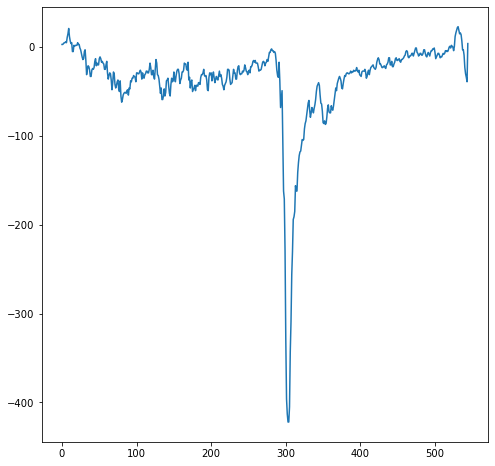

In [38]:
# filename = 'Data/SW_synthetic/testdata.mat'
# filename = 'Data/SW_synthetic/SW_Storm_50_sb_10.mat'
filename = '/media/faraday/andong/SW_synthetic/preprocess/SW_Storm_2_sb_10.mat'
filename_res = '/media/faraday/andong/SW_synthetic/Res/SW_Storm_2_sb_10.mat'

# data = sio.loadmat(filename)
data = sio.loadmat(filename, squeeze_me=True)
print(data.keys())


print(data['n_synth'].shape)
print(data['__function_workspace__'][0])
# data.interpolate(inplace=True)
# Omni_data.dropna(inplace=True)

vari_list = ['Bx_synth', 
             'By_synth',
             'Bz_synth',
             'n_synth',
             'V_synth']


date_sta = data['last_orig_time']
date = data['date']
vari = data['vari']

data_clu = []
for vari_t in vari_list:
    data_t = pd.DataFrame(data[vari_t])
    data_t.interpolate(inplace=True)

    data_clu.append(np.asarray(data_t))

real_t = pd.DataFrame(vari)
real_t.interpolate(inplace=True)
print(f'Missing value count {real_t.isna().sum()}/{len(real_t)}')

vari = np.asarray(vari)

fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(vari[:, -1])
# st()
# st()
Bx = data_clu[0]
By = data_clu[1]
Bz = data_clu[2]
N = data_clu[3]
V = data_clu[4]

B_norm = np.sqrt(Bx**2 + By**2)
# Fill missing values

date_limit = dt.datetime(int(date_sta[0]),
                         int(date_sta[1]),
                         int(date_sta[2]),
                         int(date_sta[3]),
                         int(date_sta[4]),
                        )

date_end = dt.datetime(int(date[-1, 0]),
                       int(date[-1, 1]),
                       int(date[-1, 2]),
                       int(date[-1, 3]),
                       int(date[-1, 4]),
                       )

date_clu = []
date_plot = []
for i, date_tt in tqdm(enumerate(date)):
            
    t = dt.datetime(int(date_tt[0]),
                    int(date_tt[1]),
                    int(date_tt[2]),
                    int(date_tt[3]),
                    int(date_tt[4]),
                    )
    if t == date_limit:
        idx_sel = i
    if (t > date_limit) & (t <= date_end):
    # if (t > date_limit) & (t <= date_limit+dt.timedelta(hours=24*2)):
    # if (t > date_limit-dt.timedelta(hours=6)) & (t < date_limit+dt.timedelta(hours=24*3)):
    # if (t > date_limit-dt.timedelta(hours=6)):
        date_plot.append(t) 
    date_clu.append(t) 

################# SH variables ###################

DOY = np.asarray([date.timetuple().tm_yday for date in date_clu])
year = np.asarray([date.year for date in date_clu])
month = np.asarray([date.month for date in date_clu])
dom = np.asarray([date.day for date in date_clu])
UTC = np.asarray([date.hour for date in date_clu])
date_clu = np.vstack([year, month, dom, UTC]).T
t_year = 23.4*np.cos((DOY-172)*2*np.pi/365.25)
t_day = 11.2*np.cos((UTC-16.72)*2*np.pi/24)
t = t_year+t_day
theta_c = np.arctan2(By, Bz)

print('max of t_year/day is {} {}'.format(t_year.max(), t_day.max()))

SH_vari = np.vstack([np.expand_dims(np.tile(t[idx_sel+1:], (10000, 1)), 0),
                     np.expand_dims(np.sin(theta_c), 0),
]).T

X = vari
X_real = np.tile(np.expand_dims(X, 1), (1, 10000, 1))

print('################### generating X ###############')
print(B_norm.shape)
print(X_real.shape)

X_syn = np.vstack([
    np.expand_dims(N, 0), 
    np.expand_dims(V, 0), 
    np.expand_dims(B_norm, 0), 
    np.expand_dims(Bz, 0), 
    SH_vari.T, 
    np.expand_dims(X_real[idx_sel+1:, :, -1].T, 0), 
    ]).T


X_syn = np.swapaxes(np.vstack([X_real[idx_sel-5:idx_sel+1], X_syn]), 0, 1)
X_real = np.swapaxes(X_real, 0, 1)

X_syn = np.vstack([X_real[:2, idx_sel-5:], X_syn])

print(X_syn[:, :, 3].max())
print(X_real[:2, idx_sel+1:].shape)
print(X_real.shape)
print(X_syn.shape)
print(X_real[0, :, -1].min())
print(X_syn[0, :, -1].min())

# print(np.tile(np.expand_dims(X, 1), (1, 10000, 1)).shape)



In [39]:
import h5py

with h5py.File('Data/data_'+str(delay)+
               '_'+str(Dst_sel)+'.h5', 'r') as f:

    idx = np.arange(np.array(f['num']))
    # shuffle(idx) # shuffle storm events
    idx = list(idx)
    # idx.remove(storm_idx[0])

    # print(f.keys())
    print(f['X_DL_{}'.format(idx[0])].shape)
    print(f['X_DL_{}'.format(idx[1])].shape)
    # st()
    # train
    X_train = np.array(f['X_DL_{}'.format(idx[0])][:, :, :])
    Y_train = np.array(f['Y_DL_{}'.format(idx[0])])      
    Dst_Per = np.array(f['Dst_Per{}'.format(idx[0])])        

    for i in tqdm(range(1, len(idx))):
        # import ipdb;ipdb.set_trace()
        # train_idx_clu.append(len(Y_train))
        X_train = np.vstack([X_train, \
            np.array(f['X_DL_{}'.format(idx[i])][:, :, :])
            ])
        Y_train = np.vstack([Y_train, \
            np.array(f['Y_DL_{}'.format(idx[i])])
            ])
        Dst_Per = np.hstack((Dst_Per, \
            np.array(f['Dst_Per{}'.format(idx[i])])
            ))
    # train_idx_clu.append(len(Y_train))

    # test
    X_test = np.array(f['X_DL_{}'.format(storm_idx[0])][:, :, :])
    Y_test = np.array(f['Y_DL_{}'.format(storm_idx[0])])
    Dst_Per_t = np.array(f['Dst_Per{}'.format(storm_idx[0])])
    date_test = np.array(f['date_DL_{}'.format(storm_idx[0])])

    for i in tqdm(range(1, len(storm_idx))):
    
        # test_idx_clu.append(len(Y_test))
        X_test = np.vstack([X_test,\
            np.array(f['X_DL_{}'.format(storm_idx[i])])
            ])
        Y_test = np.vstack([Y_test,\
            np.array(f['Y_DL_{}'.format(storm_idx[i])])
            ])
        Dst_Per_t = np.vstack([Dst_Per,\
            np.array(f['Dst_Per{}'.format(storm_idx[i])])
            ])
            
    # test_idx_clu.append(len(Y_test))
    
    f.close()

  0%|          | 0/60 [00:00<?, ?it/s]

(524, 6, 7)
(294, 6, 7)


100%|██████████| 60/60 [00:00<00:00, 1344.46it/s]
0it [00:00, ?it/s]


No handles with labels found to put in legend.


(10002, 256, 7)
-422.0


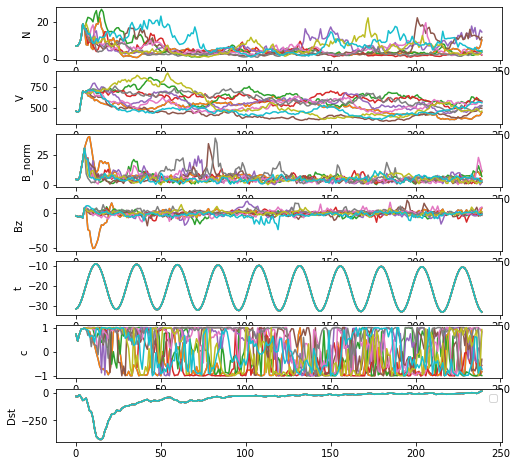

In [40]:
fig, ax = plt.subplots(7, 1, figsize=(8, 8))

names = ['N',
         'V',
         'B_norm',
         'Bz',
         't',
         'c',
         'Dst']

for i in range(len(ax)):

    ax[i].plot(X_syn[:10, :240, i].T)
    ax[i].set_ylabel(names[i])

plt.legend()
print(X_syn.shape)
print(X_syn[:, :, -1].min())


In [41]:
os.environ["CUDA_VISIBLE_DEVICES"]=str(device)

# device = torch.device("cpu") 
device = torch.device("cuda:0") 
print(device)

# fig, ax = plt.subplots(figsize=(8, 8))
# ax.plot(date_plot, X_real[0, idx-5:idx+72, -1], label='real')
# print(X_syn[:, 200, 3])


print(X_syn[:, :, 3].max())
# st()

res_clu = []
std_clu = []
X_syn_t = np.array(X_syn)

print(X_syn_t[:, :, -1].min())

for i in tqdm(range(6, 24*2)):
# for i in tqdm(range(6, X_syn.shape[1])):

    y_clu = []
    std_clu = []
    for iter_boost in range(boost_num):

        # std_clu = np.zeros([boost_num+1, 10000])
        # pred_clu = np.zeros([boost_num+1, 10000])

        # print(X_syn_t[:, :, -1].min())

        pred = train_Dst_boost(X_train[:, :, var_idx], X_train[:, :, -1], 
                        X_syn_t[:, i-6:i, var_idx], 
                        delay, Dst_sel, ratio, 
                        iter_boost, boost_num, 
                        # 1, 2,   
                        storm_idx[0], 
                        device, 
                        criteria, 
                        False)

        print(pred.shape)
        st()
        std = train_std_GRU_boost(X_train[:, :, var_idx], 
                                X_syn_t[:, :, var_idx], 
                                pred, X_syn_t[:, i-6:i, -1], 
                                pred, X_syn_t[:, i-6:i, -1], 
                                delay, 
                                Dst_sel, 
                                ratio, iter_boost, 
                                boost_num, 
                                storm_idx[0], 
                                device, 
                                pred='gru', 
                                criteria=criteria, 
                                # train=std_model, 
                                train=False
                                )
        # if iter_boost == 0:
        #     print('before/after is {}/{}'
        #         .format(X_syn_t[0, i-1, -1], pred[0, -1].squeeze()))
        #     st()
        
        if iter_boost == 0:
            y_clu = np.expand_dims(pred[:, -1], 0)
            std_clu = np.expand_dims(std, 0)
        else:
            # # st()
            # print(y_clu.shape)
            # print(pred.shape)
            # print(std_clu.shape)
            # print(std.shape)
            y_clu = np.vstack([y_clu, np.expand_dims(pred[:, -1], 0)])
            std_clu = np.vstack([std_clu, 
                                    np.expand_dims(std, 0)])
        sigma_clu = 1/(std_clu**2)

        y_t = sigma_clu*y_clu.squeeze()/sigma_clu.sum(axis=0)
        pred_final = y_t.sum(axis=0)
        X_syn_t[:, i-1, -1] = pred_final
        # X_syn_t[:, i, -1] = pred_final
    
    res_clu.append(pred_final)

    # X_syn_clu.append(X_syn_t)
    # std_clu.append(std_Y)


print(X_syn_t[:, :, -1].min())

  0%|          | 0/42 [00:00<?, ?it/s]

cuda:0
52.03353091884486
-422.0


100%|██████████| 42/42 [01:44<00:00,  2.50s/it]

-338.875


In [42]:
print(res_clu[0].shape)
res = np.zeros([res_clu[0].shape[0], len(res_clu)])
for i in range(res.shape[1]):
    res[:, i] = res_clu[i]

print(res.shape)


(10002,)
(10002, 42)


In [43]:
from scipy.ndimage import shift

y_real = shift(X_real[0, :, -1], 1, cval=0)

y_syn = np.tile(y_real, (10000, 1))
# X_real = np.tile(np.expand_dims(X, 1), (1, 10000, 1))
print(y_syn.shape)

(10000, 545)


(10002, 256, 7)


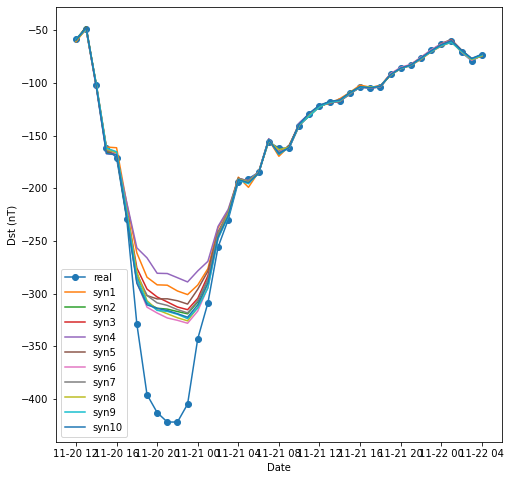

In [44]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(date_plot[1:42], y_real[idx_sel+1:idx_sel+42], 'o-',label='real')
# ax.plot(date_plot[1:], X_real[0, idx_sel+1:, -1], 'o-',label='real')
print(X_syn.shape)

# y_syn = np.tile(y_real
y_syn[:,idx_sel+1:idx_sel+42] = res[2:, :-1]

data = {"y_syn":y_syn}
# print(y_syn.shape)

sio.savemat(filename_res, data)

# with h5py.File(filename, 'a') as f:
#     print(f.keys())
#     f.create_dataset('y_syn', data = y_syn)
#     # sio.savemat(f, data)   # append
#     f.close()

# aa = sio.loadmat(filename)
# print(aa)

# print(sio.loadmat(filename, 'r').keys())

for i in range(10):

    # if i == 0:
    #     ax.plot(date_plot, res[i*200, 1:], 'syn'+str(i+1))
    #     # ax.plot(date_plot, res[i*2500, 1:], label='pred')
    # else:
    # ax.plot(res[i*10, :].squeeze(), label='syn'+str(i+1))
    ax.plot(date_plot[1:42], y_syn[i*100, idx_sel+1:idx_sel+42], label='syn'+str(i+1))
plt.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Dst (nT)')
plt.savefig('Figs/syn.png')

In [11]:
print(idx_sel)
print(X_real.shape)
print(date.shape)

294
(10000, 545, 7)
(545, 5)
